In [0]:
# -------------------------------------------------------------------------- #
# install wits data analysis module: wits
# -------------------------------------------------------------------------- #

%pip install /dbfs/FileStore/jars/3c5b9ded_3a8e_463c_a1ad_3325607c940e/wits_pro-1.0.2-py3-none-any.whl

Python interpreter will be restarted.
Processing /dbfs/FileStore/jars/3c5b9ded_3a8e_463c_a1ad_3325607c940e/wits_pro-1.0.2-py3-none-any.whl
Installing collected packages: wits-pro
Successfully installed wits-pro-1.0.2
Python interpreter will be restarted.

In [0]:
# -------------------------------------------------------------------------- #
# load various modules and define constants                                  #
# -------------------------------------------------------------------------- #

from wits import clean as wits_clean
from wits import load as wits_load
from wits import signal as wits_pro
from wits.signal import activity
from wits.signal import anova as wits_anova
from wits.signal import depth as wits_depth
from wits import utilities as wits_utils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib.patches as mpatches
import datetime as dt
import time
import seaborn as sns

In [0]:
def data_cleaning(df):
  df = wits_clean.filter_duplicates(df, 'RecordDateTime')
  df = wits_clean.resample(df, 'RecordDateTime', frequency='1.0S', fill_limit=5)
  df = df.sort_values('RecordDateTime')
  return df

def remove_transition_data(df, margin_width = 1.0):
  """
  Based on "In Slips" mode hole depth to determine the transition depth that need to be removed.
  """
  mask_slip = df['state'] =='In Slips'
  in_slip_hole_depths = df[mask_slip]['hole_depth'].unique()
  df['InTransition'] = False
  for depth in in_slip_hole_depths:
    tail_filter = ((df['bit_depth'] < depth + margin_width)& (df['bit_depth'] > depth - margin_width))
    df.loc[tail_filter, 'InTransition'] = True
  return df[df['InTransition']==False]
      
def assign_stand_no(df):
  mask_slip = df['state'] =='In Slips'
  in_slip_hole_depths = df[mask_slip]['hole_depth'].unique()
  df['standNo'] = -1
  stand_num = 0
  mask_stand = (df['bit_depth']<=in_slip_hole_depths[0])
  df.loc[mask_stand, 'standNo'] = stand_num
  stand_num += 1
  for i_depth in range(len(in_slip_hole_depths)-1):
    slip_depth_i = in_slip_hole_depths[i_depth] 
    slip_depth_i_1 = in_slip_hole_depths[i_depth+1]
    mask_stand= ((df['bit_depth']<=slip_depth_i_1)& (df['bit_depth'] >=slip_depth_i))
    df.loc[mask_stand, 'standNo'] = stand_num
    stand_num += 1
  df = df[df['standNo']!=-1] 
  return df


def plot_stand_stats(df, columns, stat, start_depth, end_depth, fig_title, threhold= 0.5):
  df = df.copy()
  mask = (df['hole_depth'] == df['bit_depth'])
  df = df[mask]
  df_group = df.groupby(by='standNo')
  df_group = df_group.agg({'max', 'min', 'mean', 'std', 'median'})

  x = df_group['bit_depth']['mean']
  max_x = df_group['bit_depth']['max'] 
  min_x = df_group['bit_depth']['min']
  
  
  def add_line_plot(margin, min_x, max_x):
    for i in range(df_group.shape[0]):
      margin = 2.0
      x_min = min_x[i]
      x_max = max_x[i]
      if x_max-x_min < 50:
        if y[i]<threhold:
          line_color = 'green'
        else:
          line_color = 'red'
        ax.plot([x_min+margin, x_max-margin], [y[i], y[i]],  linewidth=5, color = line_color, alpha = 0.5)
        
  plt.style.use('seaborn')
  sns.set(font_scale=1)
  fig, axes = plt.subplots(len(columns), figsize = (15, 8))
  axes = axes.ravel()
  plt.suptitle(fig_title+ ' ' + stat)

  for column, ax in zip(columns, axes):
    y = df_group[column][stat]/df_group[column]['mean']
    ax.plot(x[1:], y[1:], '-o')
    ax.set(ylabel=column, xlabel ='Bit Depth (m)')
    ax.set_xlim(start_depth, end_depth)
    ax.set_ylim(0)
    add_line_plot(2.0, min_x, max_x)
  plt.tight_layout()
  fig.subplots_adjust(top=0.95)
  
def plot_stand_historgram():
    df = df.copy()
    mask = (df['hole_depth'] == df['bit_depth'])
    df = df[mask]
    df_group = df.groupby(by='standNo')
    df_group = df_group.agg({'max', 'min', 'mean', 'std', 'median'})

    x = df_group['bit_depth']['mean']
    max_x = df_group['bit_depth']['max'] 
    min_x = df_group['bit_depth']['min']


    def add_line_plot(margin, min_x, max_x):
      for i in range(df_group.shape[0]):
        margin = 2.0
        x_min = min_x[i]
        x_max = max_x[i]
        if x_max-x_min < 50:
          if y[i]<threhold:
            line_color = 'green'
          else:
            line_color = 'red'
          ax.plot([x_min+margin, x_max-margin], [y[i], y[i]],  linewidth=5, color = line_color, alpha = 0.5)

    plt.style.use('seaborn')
    sns.set(font_scale=1)
    fig, axes = plt.subplots(len(columns), figsize = (15, 8))
    axes = axes.ravel()
    plt.suptitle(fig_title+ ' ' + stat)

    for column, ax in zip(columns, axes):
      y = df_group[column][stat]/df_group[column]['mean']
      ax.plot(x[1:], y[1:], '-o')
      ax.set(ylabel=column, xlabel ='Bit Depth (m)')
      ax.set_xlim(start_depth, end_depth)
      ax.set_ylim(0)
      add_line_plot(2.0, min_x, max_x)
    plt.tight_layout()
    fig.subplots_adjust(top=0.95)

class WITS_STAND_STATS(object):
  def __init__(self, df):
    self.df = df.copy()
    self.df_group = []
    
  def remove_transition_data(self, margin_width = 1.0):
    """
    Based on "In Slips" mode hole depth to determine the transition depth that need to be removed.
    """
    mask_slip = self.df['state'] =='In Slips'
    in_slip_hole_depths = self.df[mask_slip]['hole_depth'].unique()
    self.df['InTransition'] = False
    for depth in in_slip_hole_depths:
      tail_filter = ((self.df['bit_depth'] < depth + margin_width)& (self.df['bit_depth'] > depth - margin_width))
      self.df.loc[tail_filter, 'InTransition'] = True
    return self.df[self.df['InTransition']==False]

  def assign_stand_no(self):
      mask_slip = self.df['state'] =='In Slips'
      in_slip_hole_depths = self.df[mask_slip]['hole_depth'].unique()
      self.df['standNo'] = -1
      stand_num = 0
      mask_stand = (self.df['bit_depth']<=in_slip_hole_depths[0])
      self.df.loc[mask_stand, 'standNo'] = stand_num
      stand_num += 1
      for i_depth in range(len(in_slip_hole_depths)-1):
        slip_depth_i = in_slip_hole_depths[i_depth] 
        slip_depth_i_1 = in_slip_hole_depths[i_depth+1]
        mask_stand= ((self.df['bit_depth']<=slip_depth_i_1)& (self.df['bit_depth'] >=slip_depth_i))
        self.df.loc[mask_stand, 'standNo'] = stand_num
        stand_num += 1
      self.df = self.df[self.df['standNo']!=-1] 
      
  def form_group_by_stand(self):
    mask = (self.df['hole_depth'] == self.df['bit_depth'])
    self.df = self.df[mask]
    self.df_group = self.df.groupby(by='standNo')
    return self.df_group
  
  def aggregate_stats(self):
    self.df_group = self.df_group.agg({'mean', 'max', 'min', 'std', 'median'})
    return self.df_group
  
  def _add_line_plot(self, margin, min_x, max_x, y, ax):
    for i in range(self.df_group.shape[0]):
      x_min = min_x[i]
      x_max = max_x[i]
      line_color = 'red'
      if x_max-x_min < 50:
        if y[i]<threhold:
          line_color = 'green'
        else:
          line_color = 'red'
        ax.plot([x_min+margin, x_max-margin], [y[i], y[i]])    

  
  def show_stand_stats(self, columns, stat, start_depth, end_depth, fig_title, threhold= 0.5):
    plt.style.use('seaborn')
    sns.set(font_scale=1)
    fig, axes = plt.subplots(len(columns), figsize = (15, 8))
    axes = axes.ravel()
    plt.suptitle(fig_title+ ' ' + stat)
    
    x = self.df_group['bit_depth']['mean']
    max_x = self.df_group['bit_depth']['max'] 
    min_x = self.df_group['bit_depth']['min']
    
    def add_line_plot(margin, min_x, max_x):
      for i in range(self.df_group.shape[0]):
        margin = 2.0
        x_min = min_x[i]
        x_max = max_x[i]
        if x_max-x_min < 50:
          if y[i]<threhold:
            line_color = 'green'
          else:
            line_color = 'red'
          ax.plot([x_min+margin, x_max-margin], [y[i], y[i]],  linewidth=5, color = line_color, alpha = 0.5)
          
    for column, ax in zip(columns, axes):
      y = self.df_group[column][stat]/self.df_group[column]['mean']
      ax.plot(x[1:], y[1:], '-o')
      ax.set(ylabel=column, xlabel ='Bit Depth (m)')
      ax.set_xlim(start_depth, end_depth)
      #ax.set_ylim(0)
      add_line_plot(2.0, min_x, max_x)
    plt.tight_layout()
    fig.subplots_adjust(top=0.95)
    

  def show_histogram(self, columns, stat, start_depth, end_depth, fig_title):
    plt.style.use('seaborn')
    sns.set(font_scale=1)
    fig, axes = plt.subplots(len(columns), figsize = (15, 8))
    axes = axes.ravel()
    plt.suptitle(fig_title+ ' ' + stat)
    
    for column, ax in zip(columns, axes):
      y = self.df_group[column]['std']/self.df_group[column]['mean'] if stat == 'std' else self.df_group[column][stat]
      lower, upper = np.percentile(y, [2, 98])
      sns.distplot(y, bins = np.linspace(lower, upper, 50), kde=False, ax = ax)
      ax.set(xlabel=column)

    plt.tight_layout()
    fig.subplots_adjust(top=0.95)
  

In [0]:
df_29 = spark.sql("SELECT * from sandbox.BdC_29_3000_6000")
df_29 = df_29.toPandas()
df_45 = spark.sql("SELECT * from sandbox.BdC_45_3000_6000")
df_45 = df_45.toPandas()

In [0]:
# Basic DataCleaning
df_29 = data_cleaning(df_29)
df_45 = data_cleaning(df_45)

In [0]:
df_29_copy = remove_transition_data(df_29.copy(), margin_width=1.0)
df_45_copy = remove_transition_data(df_45.copy(), margin_width=1.0)

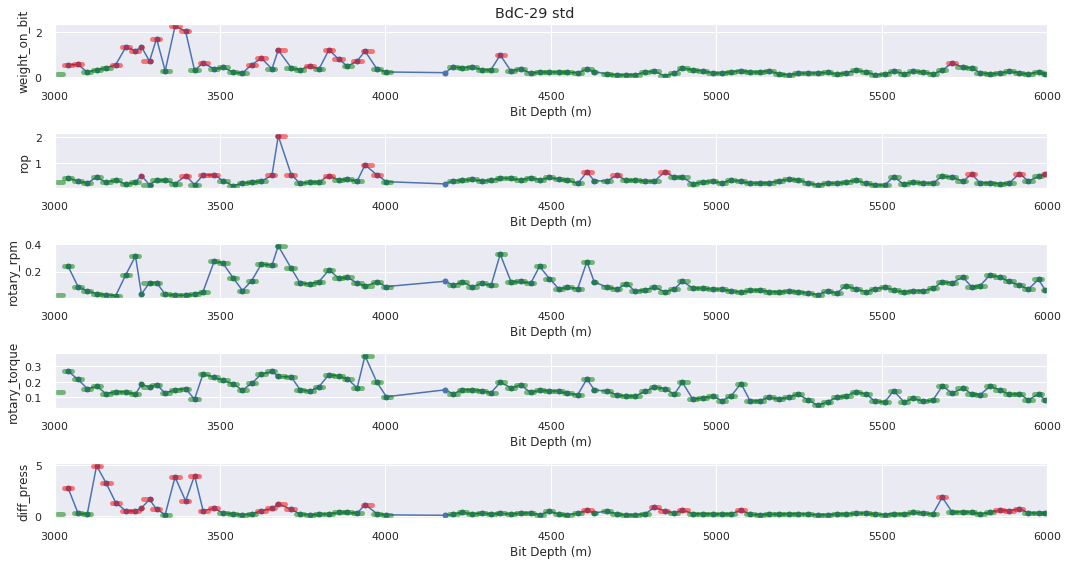

In [0]:
wits_stand_stats = WITS_STAND_STATS(df_29.copy())
wits_stand_stats.remove_transition_data(margin_width = 1.0)
wits_stand_stats.assign_stand_no()
wits_stand_stats.form_group_by_stand()
wits_stand_stats.aggregate_stats()

wits_stand_stats.show_stand_stats(columns=['weight_on_bit','rop','rotary_rpm', 'rotary_torque','diff_press'], stat='std', start_depth =3000, end_depth = 6000, fig_title='BdC-29') 

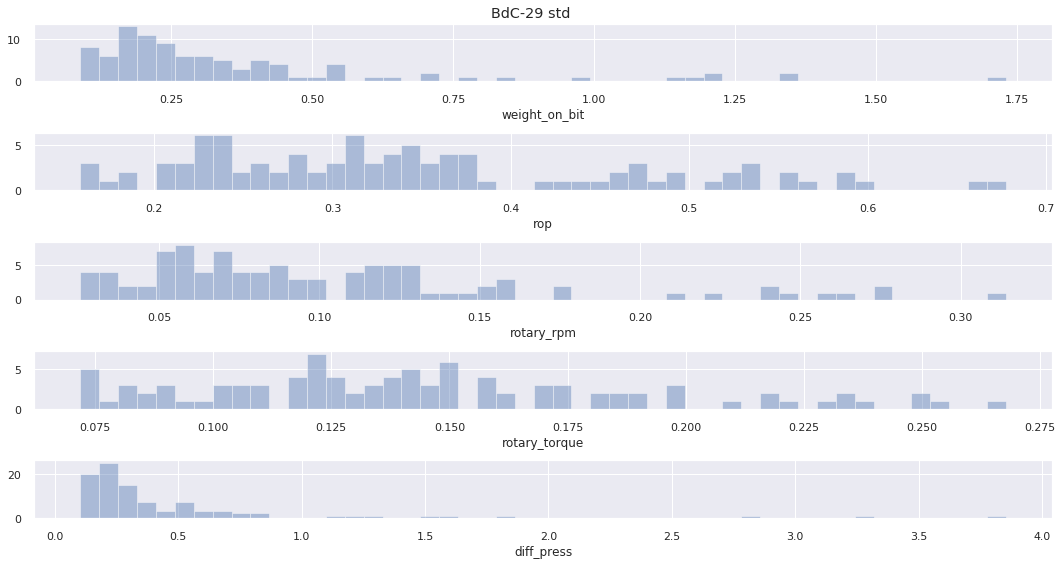

In [0]:
wits_stand_stats.show_histogram(columns=['weight_on_bit','rop','rotary_rpm', 'rotary_torque','diff_press'], stat='std', start_depth =3000, end_depth = 6000, fig_title='BdC-29') 

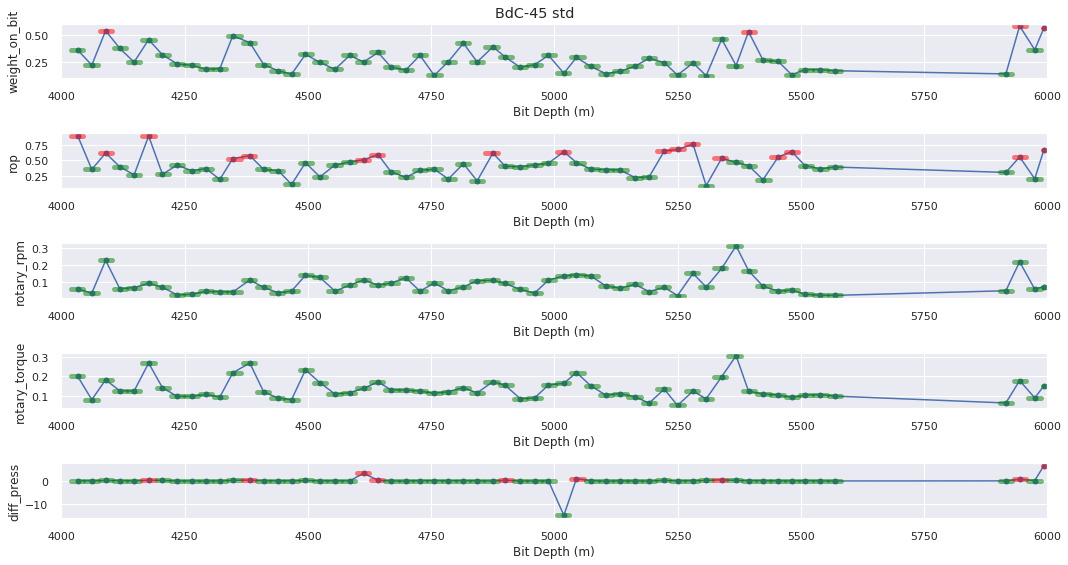

In [0]:
wits_stand_stats = WITS_STAND_STATS(df_45.copy())
wits_stand_stats.remove_transition_data(margin_width = 1.0)
wits_stand_stats.assign_stand_no()
wits_stand_stats.form_group_by_stand()
wits_stand_stats.aggregate_stats()

wits_stand_stats.show_stand_stats(columns=['weight_on_bit','rop','rotary_rpm', 'rotary_torque','diff_press'], stat='std', start_depth =4000, end_depth = 6000, fig_title='BdC-45') 

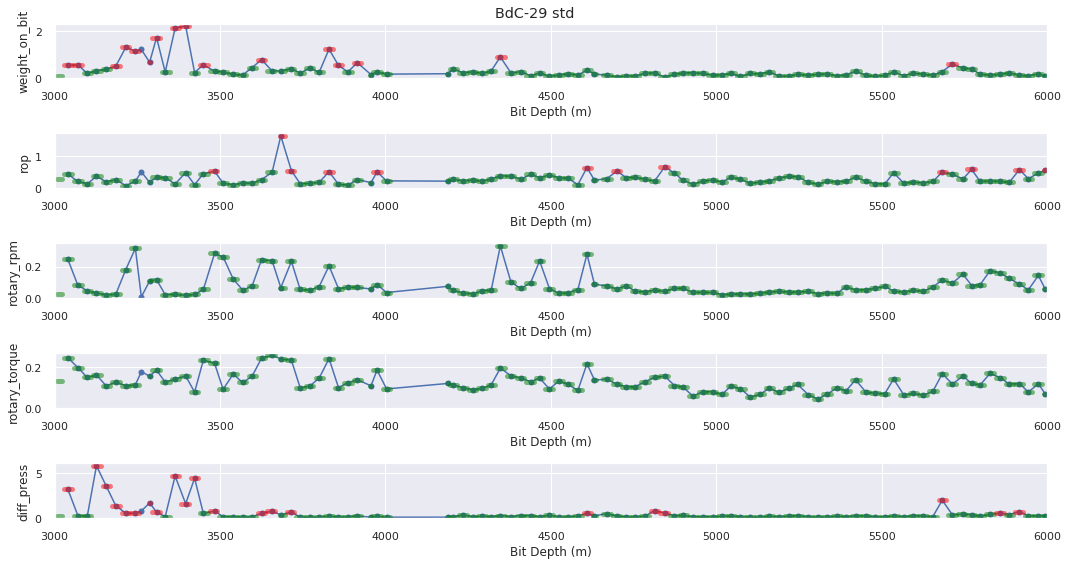

In [0]:
columns = ['weight_on_bit', 'rotary_rpm', 'rotary_torque', 'rop', 'diff_press']
df_29_temp = assign_stand_no(df_29.copy())
df_29_temp = remove_transition_data(df_29_temp.copy(), margin_width=1.0)
plot_stand_stats(df_29_temp, columns=['weight_on_bit','rop','rotary_rpm', 'rotary_torque','diff_press'], stat='std', start_depth =3000, end_depth = 6000, fig_title='BdC-29') 

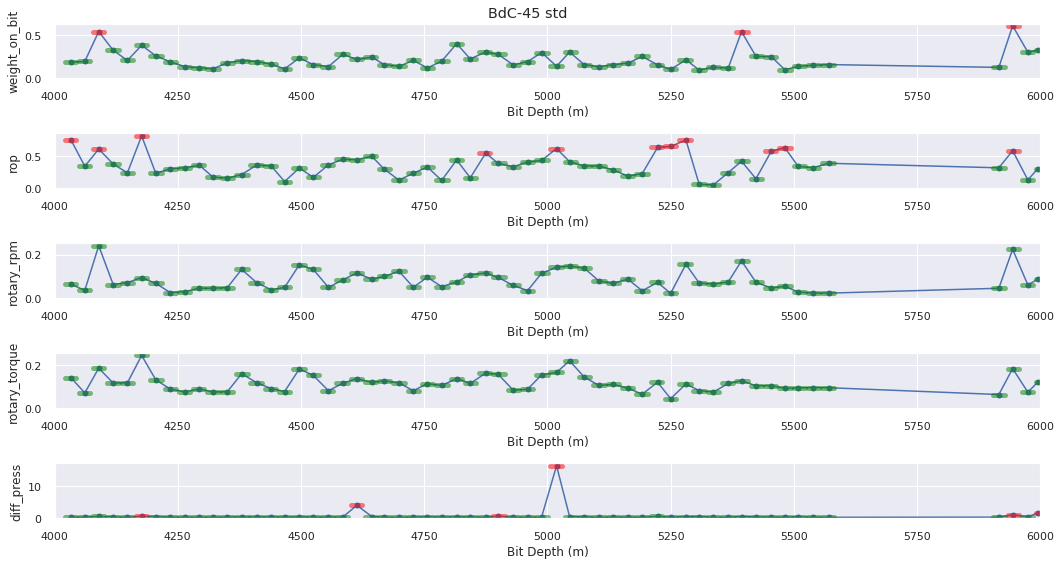

In [0]:
columns = ['weight_on_bit', 'rotary_rpm', 'rotary_torque', 'rop', 'diff_press']
df_45_temp = assign_stand_no(df_45.copy())
df_45_temp = remove_transition_data(df_45_temp.copy(), margin_width=1.0)
plot_stand_stats(df_45_temp, columns=['weight_on_bit','rop','rotary_rpm', 'rotary_torque','diff_press'], stat='std', start_depth =4000, end_depth = 6000, fig_title='BdC-45')